# Malware Image Classification Project

The Malimg Dataset - a publicly available benchmark dataset for malware images - contains 9339 malware images, belonging to 25 families/classes. Thus, our goal is to train a model to perform a multi-class classification of these malware images.

To do this we are going to use a famous Imagenet model called InceptionV3 to do Transfer Learning.

Interestingly, normalizing the values gave validation accuracy of 92% whilst using the original values gave 95% instead.

Malimg  - https://www.dropbox.com/s/ep8qjakfwh1rzk4/malimg_dataset.zip

Student - Tan Yong He


In [ ]:
!ls

sample_data


## Testing for GPU 

Tests if you have GPU set up.

If no GPU is found press Runtime (in the top menu) and choose "Change Runtime Type" to GPU.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download the Data

By placing ! infront we can run almost any Linux shell command.

In [ ]:
!wget -qq https://www.dropbox.com/s/ep8qjakfwh1rzk4/malimg_dataset.zip
  
!unzip -qq malimg_dataset.zip
!rm malimg_dataset.zip

!ls

malimg_paper_dataset_imgs  sample_data


In [ ]:
!ls malimg_paper_dataset_imgs

 Adialer.C	  C2LOP.P	   Lolyda.AA3		      'Swizzor.gen!E'
 Agent.FYI	  Dialplatform.B   Lolyda.AT		      'Swizzor.gen!I'
 Allaple.A	  Dontovo.A	  'Malex.gen!J'		       VB.AT
 Allaple.L	  Fakerean	   malimg_dataset_readme.txt   Wintrim.BX
'Alueron.gen!J'   Instantaccess    Obfuscator.AD	       Yuner.A
 Autorun.K	  Lolyda.AA1	  'Rbot!gen'
'C2LOP.gen!g'	  Lolyda.AA2	   Skintrim.N


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import tensorflow as tf

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback




In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.3.0
2.4.0


In [ ]:
# Set up some hyperparameters

num_classes = 25

img_height = 224
img_width = 244

batch_size = 128
epochs = 10

lr = 0.001

## Preprocessing the data

In [ ]:
import sys
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image

train_data_dir = "malimg_paper_dataset_imgs"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    horizontal_flip = True,
    validation_split = 0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode ='categorical',
    subset ='validation') # set as validation data

Found 7481 images belonging to 25 classes.
Found 1858 images belonging to 25 classes.


In [ ]:
# See all 25 different classes
train_generator.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

Found 9339 images belonging to 25 classes.


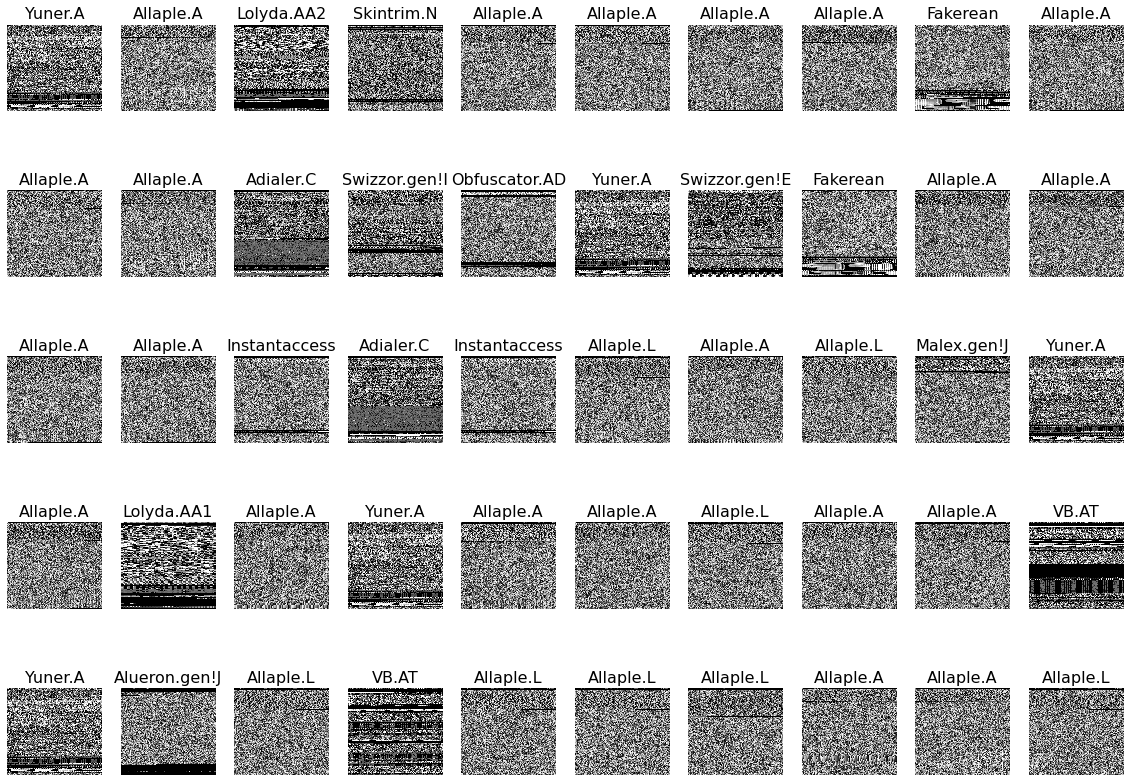

In [ ]:
# Plots images with labels within the Jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# To take a look at some of our images
batches = ImageDataGenerator().flow_from_directory(directory=train_data_dir, target_size=(img_height, img_width), batch_size=1000)
imgs, labels = next(batches)
plots(imgs, titles = labels)

## Choosing a Pre-trained Network for Transfer Learning




In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Creating a Simple Head for Model Training

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Creating the model for training
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the InceptionV3 layers except the BatchNorm
for layer in base_model.layers:
    if 'batch' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 

batch_normalization
batch_normalization_1
batch_normalization_2
batch_normalization_3
batch_normalization_4
batch_normalization_8
batch_normalization_6
batch_normalization_9
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
batch_normalization_15
batch_normalization_13
batch_normalization_16
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
batch_normalization_22
batch_normalization_20
batch_normalization_23
batch_normalization_19
batch_normalization_21
batch_normalization_24
batch_normalization_25
batch_normalization_27
batch_normalization_28
batch_normalization_26
batch_normalization_29
batch_normalization_34
batch_normalization_35
batch_normalization_31
batch_normalization_36
batch_normalization_32
batch_normalization_37
batch_normalization_30
batch_normalization_33
batch_normalization_38
batch_normalization_39
batch_normalization_44
batch_normalization_45
batch_normalization_41
batch_normalization_46


In [ ]:
for layer in model.layers:
  print(layer.name)
  print(layer.trainable)

input_1
False
conv2d
False
batch_normalization
True
activation
False
conv2d_1
False
batch_normalization_1
True
activation_1
False
conv2d_2
False
batch_normalization_2
True
activation_2
False
max_pooling2d
False
conv2d_3
False
batch_normalization_3
True
activation_3
False
conv2d_4
False
batch_normalization_4
True
activation_4
False
max_pooling2d_1
False
conv2d_8
False
batch_normalization_8
True
activation_8
False
conv2d_6
False
conv2d_9
False
batch_normalization_6
True
batch_normalization_9
True
activation_6
False
activation_9
False
average_pooling2d
False
conv2d_5
False
conv2d_7
False
conv2d_10
False
conv2d_11
False
batch_normalization_5
True
batch_normalization_7
True
batch_normalization_10
True
batch_normalization_11
True
activation_5
False
activation_7
False
activation_10
False
activation_11
False
mixed0
False
conv2d_15
False
batch_normalization_15
True
activation_15
False
conv2d_13
False
conv2d_16
False
batch_normalization_13
True
batch_normalization_16
True
activation_13
False
act

## Selecting an Optimizer 

In [ ]:
# Set tf.keras optimizer
opt = optimizers.Adam(lr)

## Compiling the Model

In [ ]:
# Compile the model 
model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

## Setting Callbacks

In [ ]:
!mkdir checkpoints

checkpoint = ModelCheckpoint('./checkpoints/best_weights.hdf5', verbose=1, save_best_only=True, mode='auto')

## Fitting the Model

We pass in:
- training set (as a data generator)
- number of steps for training
- validation set (as a data generator)
- number of steps for validation
- number of epochs

In [ ]:
## Train the model with validation 
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // batch_size,
                    epochs = epochs)

Epoch 1/10
58/58 [==============================] - 100s 2s/step - loss: 1.2651 - accuracy: 0.6916 - val_loss: 3.7119 - val_accuracy: 0.0926
Epoch 2/10
58/58 [==============================] - 95s 2s/step - loss: 0.3171 - accuracy: 0.9169 - val_loss: 3.4748 - val_accuracy: 0.1814
Epoch 3/10
58/58 [==============================] - 95s 2s/step - loss: 0.1969 - accuracy: 0.9421 - val_loss: 3.5304 - val_accuracy: 0.2852
Epoch 4/10
58/58 [==============================] - 95s 2s/step - loss: 0.1532 - accuracy: 0.9523 - val_loss: 3.4792 - val_accuracy: 0.3315
Epoch 5/10
58/58 [==============================] - 95s 2s/step - loss: 0.1324 - accuracy: 0.9569 - val_loss: 2.6406 - val_accuracy: 0.4509
Epoch 6/10
58/58 [==============================] - 95s 2s/step - loss: 0.1146 - accuracy: 0.9642 - val_loss: 2.1514 - val_accuracy: 0.5190
Epoch 7/10
58/58 [==============================] - 95s 2s/step - loss: 0.1042 - accuracy: 0.9675 - val_loss: 1.9899 - val_accuracy: 0.5536
Epoch 8/10
58/58 [=

In [ ]:
scores = model.evaluate_generator(validation_generator, validation_generator.samples/batch_size, workers=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [ ]:
print('Final CNN Accuracy: ', scores[1])

Final CNN Accuracy:  0.9284176826477051


## Making a Confusion Matrix

In [ ]:
y_pred_prob = model.predict(imgs/255.)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test = np.argmax(labels, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
import seaborn as sns

def pretty_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


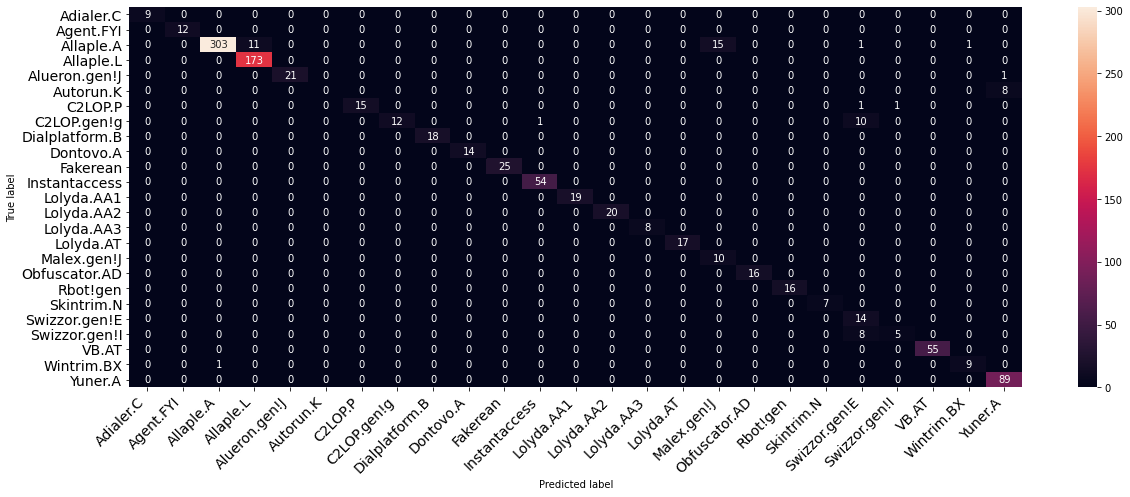

In [ ]:
class_names = batches.class_indices.keys()
pretty_confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

## Saving the Model and Weights on Colab 

In [ ]:
# Saving model and model weights to Colab's file directory
model.save('malimg.h5')
model.save_weights('malimg_weights.h5', save_format='h5')

## Saving the Model and Weights Back to Local Machine

In [ ]:
# Downloading from Colab's file directory to our local machine

from google.colab import files

files.download('malimg.h5')
files.download('malimg_weights.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>